# Classification using Word2Vec

## Imports

In [2]:
import numpy as np
import torch
import torch.nn.functional as F
import torch.nn as nn
import math
from torch.utils.data import DataLoader
from datasets import load_dataset
from tabulate import tabulate

from tqdm.notebook import tqdm
from transformers import BertTokenizer

/Users/simon/Developer/iasd/env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data preparation

In [3]:
dataset = load_dataset("scikit-learn/imdb", split="train")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", do_lower_case=True)

VOCSIZE = len(tokenizer.vocab)
print("Length of the vocabulary:", VOCSIZE)

Length of the vocabulary: 30522


In [5]:
def preprocessing_fn(x, tokenizer):
    x["review_ids"] = tokenizer(
        x["review"],
        add_special_tokens=False,
        truncation=True,
        max_length=256,
        padding=False,
        return_attention_mask=False,
    )["input_ids"]
    x["label"] = 0 if x["sentiment"] == "negative" else 1
    return x

n_samples = 5000  # the number of training example

# We first shuffle the data !
dataset = dataset.shuffle()

# Select 5000 samples
splitted_dataset = dataset.select(range(n_samples))

# Tokenize the dataset
splitted_dataset = splitted_dataset.map(
    preprocessing_fn, fn_kwargs={"tokenizer": tokenizer}
)


# Remove useless columns
splitted_dataset = splitted_dataset.select_columns(["review_ids", "label"])

# Split the train and validation
splitted_dataset = splitted_dataset.train_test_split(test_size=0.2)

train_set = splitted_dataset["train"]
valid_set = splitted_dataset["test"]

Map: 100%|██████████| 5000/5000 [00:10<00:00, 466.64 examples/s]


In [8]:
class DataCollator:
    def __init__(self, tokenizer):
        self.tokenizer = tokenizer

    def __call__(self, batch):
        # `batch` is a list of dictionary with keys "review_ids" and "label".
        features = [{"input_ids": x["review_ids"]} for x in batch]
        features = self.tokenizer.pad(
            features, padding="max_length", max_length=256, return_tensors="pt"
        )
        label = torch.tensor([x["label"] for x in batch])[:, None]
        return {"review_ids": features["input_ids"], "label": label}

data_collator = DataCollator(tokenizer)

In [9]:
batch_size = 32

train_dataloader = DataLoader(
    train_set, batch_size=batch_size, collate_fn=data_collator
)
valid_dataloader = DataLoader(
    valid_set, batch_size=batch_size, collate_fn=data_collator
)
n_valid = len(valid_set)
n_train = len(train_set)

## Model

In [25]:
class Conv1dClassifier(nn.Module):
    """A text classifier:
    - input = minibatch
    - output = probability associated to a binary classification task
    - vocab_size: the number of words in the vocabulary we want to embed
    - embedding_dim: size of the word vectors
    """

    def __init__(self, vocab_size: int, embeddings: nn.Embedding, feature_size: int = 100, kernel_size: int = 3):
        super().__init__()
        self.feature_size = feature_size
        self.embeddings = embeddings
        self.embedding_dim = self.embeddings.embedding_dim

        self.conv = nn.Conv1d(
            self.embedding_dim,
            feature_size,
            kernel_size,
            padding=math.floor(kernel_size / 2),
        )

        self.pool = nn.AdaptiveMaxPool1d(1)
        self.dropout = nn.Dropout(0.3)
        self.linear = nn.Linear(feature_size, 1)
        self.out_activation = nn.Sigmoid()

    def forward(self, input_ids: torch.Tensor):
        # In pytorch, convolution expects (B,d,L)
        # B: the batch dimension
        # d: the embedding dimension
        # L: the length of the sequence
        hidden_states = self.embeddings(input_ids).permute(0, 2, 1)
        hidden_states = F.relu(self.conv(hidden_states))
        hidden_states = self.pool(hidden_states)  # --> (B,d,1)
        # Before the linear, do something with dims the dimension
        # Because Linear works on the final dim
        # (B,d,1) -> (B,d)
        hidden_states = hidden_states.squeeze(dim=2)
        hidden_states = self.dropout(hidden_states)
        logits = self.linear(hidden_states)
        return self.out_activation(logits)

In [56]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def load_model(path: str):
  torch.serialization.add_safe_globals([nn.Embedding, set])
  trained_embeddings = torch.load(path, map_location=device, weights_only=True)
  trained_embeddings.weight.requires_grad = False

  return Conv1dClassifier(
    vocab_size=VOCSIZE,
    embeddings=trained_embeddings,
  )


model_default = Conv1dClassifier(
  vocab_size=VOCSIZE,
  embeddings=nn.Embedding(VOCSIZE, 25),
)

model_pretrained = load_model('model_dim-25_radius-10_ratio-5-batch-1200-epoch-10.ckpt')


# Test on random sentence

random_inputs = torch.randint(0, VOCSIZE, (4, 100))

with torch.no_grad():
  print(torch.stack([
    model_default(random_inputs),
    model_pretrained(random_inputs),
  ]).squeeze().T)

tensor([[0.0670, 0.4582],
        [0.2049, 0.3479],
        [0.4247, 0.2501],
        [0.3290, 0.2709]])


## Training

100%|██████████| 32/32 [00:00<00:00, 44.40it/s]


Epoch 1/16 Train Loss: 0.43 Train Acc: 79.70%  | Valid Loss: 0.49 Valid Acc: 76.00%


100%|██████████| 32/32 [00:00<00:00, 45.15it/s]


Epoch 2/16 Train Loss: 0.41 Train Acc: 81.17%  | Valid Loss: 0.48 Valid Acc: 76.10%


100%|██████████| 32/32 [00:00<00:00, 36.07it/s]


Epoch 3/16 Train Loss: 0.40 Train Acc: 82.85%  | Valid Loss: 0.47 Valid Acc: 76.20%


100%|██████████| 32/32 [00:00<00:00, 45.16it/s]


Epoch 4/16 Train Loss: 0.37 Train Acc: 83.30%  | Valid Loss: 0.47 Valid Acc: 76.90%


100%|██████████| 32/32 [00:00<00:00, 42.80it/s]


Epoch 5/16 Train Loss: 0.35 Train Acc: 85.35%  | Valid Loss: 0.47 Valid Acc: 76.80%


100%|██████████| 32/32 [00:00<00:00, 37.21it/s]


Epoch 6/16 Train Loss: 0.34 Train Acc: 85.33%  | Valid Loss: 0.46 Valid Acc: 77.10%


100%|██████████| 32/32 [00:00<00:00, 40.71it/s]


Epoch 7/16 Train Loss: 0.33 Train Acc: 85.88%  | Valid Loss: 0.47 Valid Acc: 77.00%


100%|██████████| 32/32 [00:01<00:00, 29.28it/s]


Epoch 8/16 Train Loss: 0.29 Train Acc: 87.62%  | Valid Loss: 0.46 Valid Acc: 77.30%


100%|██████████| 32/32 [00:00<00:00, 43.77it/s]


Epoch 9/16 Train Loss: 0.29 Train Acc: 88.58%  | Valid Loss: 0.47 Valid Acc: 76.80%


100%|██████████| 32/32 [00:00<00:00, 40.15it/s]


Epoch 10/16 Train Loss: 0.27 Train Acc: 89.30%  | Valid Loss: 0.46 Valid Acc: 76.90%


100%|██████████| 32/32 [00:00<00:00, 42.20it/s]


Epoch 11/16 Train Loss: 0.26 Train Acc: 89.50%  | Valid Loss: 0.47 Valid Acc: 76.90%


100%|██████████| 32/32 [00:00<00:00, 39.32it/s]


Epoch 12/16 Train Loss: 0.24 Train Acc: 90.45%  | Valid Loss: 0.46 Valid Acc: 77.50%


100%|██████████| 32/32 [00:00<00:00, 32.79it/s]


Epoch 13/16 Train Loss: 0.22 Train Acc: 91.55%  | Valid Loss: 0.46 Valid Acc: 77.10%


100%|██████████| 32/32 [00:00<00:00, 44.43it/s]


Epoch 14/16 Train Loss: 0.21 Train Acc: 91.28%  | Valid Loss: 0.47 Valid Acc: 77.80%


100%|██████████| 32/32 [00:00<00:00, 43.88it/s]


Epoch 15/16 Train Loss: 0.19 Train Acc: 92.80%  | Valid Loss: 0.47 Valid Acc: 77.70%


100%|██████████| 32/32 [00:01<00:00, 28.20it/s]


Epoch 16/16 Train Loss: 0.18 Train Acc: 93.10%  | Valid Loss: 0.48 Valid Acc: 77.20%


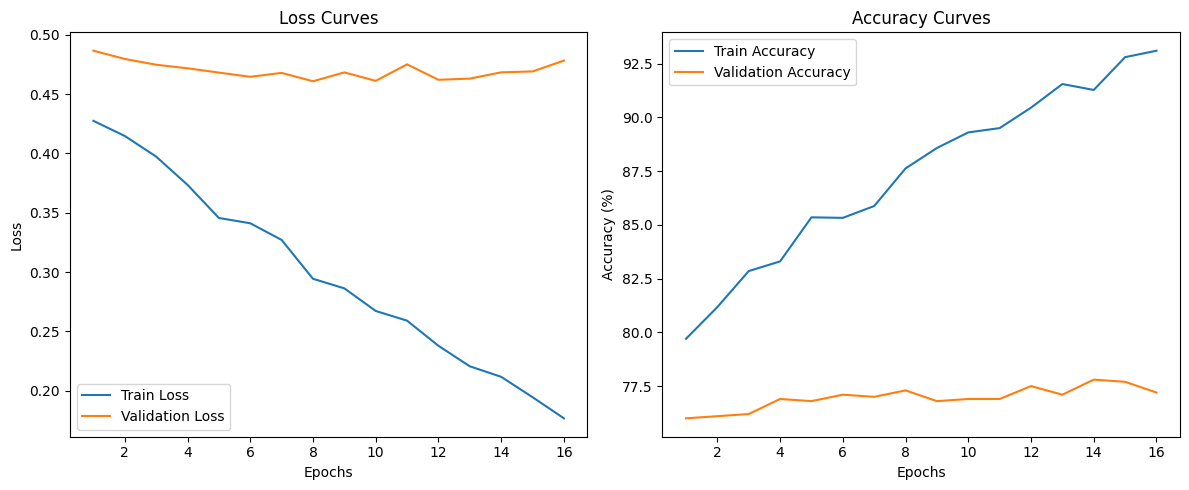

In [61]:
import matplotlib.pyplot as plt
from tqdm import tqdm

def train_model(model: nn.Module):
  loss_function = nn.BCELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
  n_epochs = 16
  train_losses = []
  valid_losses = []
  train_accs = []
  valid_accs = []

  model.to(device)


  def compute_accuracy(predictions, labels):
      pred = (predictions > 0.5).int()
      correct = (labels == pred).sum().item()
      return correct


  def train_one_epoch(model, dataloader, optimizer, loss_function):
      model.train()
      total_loss = 0
      correct = 0
      total_batches = len(dataloader)

      for batch in tqdm(dataloader, leave=True):
          batch = {k: v.to(device) for k, v in batch.items()}
          optimizer.zero_grad()
          probs = model(batch["review_ids"])
          gold = batch["label"]

          correct += compute_accuracy(probs, gold)
          loss = loss_function(probs, gold.float())
          loss.backward()
          optimizer.step()
          total_loss += loss.item()

      avg_loss = total_loss / total_batches
      avg_accuracy = (correct * 100) / n_train  # Calculate accuracy in percentage
      return avg_loss, avg_accuracy


  def validate_one_epoch(model, dataloader, loss_function):
      model.eval()
      total_loss = 0
      correct = 0
      total_batches = len(dataloader)

      with torch.no_grad():
          for batch in tqdm(dataloader, leave=True):
              batch = {k: v.to(device) for k, v in batch.items()}
              probs = model(batch["review_ids"])
              gold = batch["label"]

              correct += compute_accuracy(probs, gold)
              loss = loss_function(probs, gold.float())
              total_loss += loss.item()

      avg_loss = total_loss / total_batches
      avg_accuracy = (correct * 100) / n_valid  # Calculate accuracy in percentage
      return avg_loss, avg_accuracy


  for epoch in range(n_epochs):
      train_avg_loss, train_avg_acc = train_one_epoch(
          model, train_dataloader, optimizer, loss_function
      )
      valid_avg_loss, valid_avg_acc = validate_one_epoch(
          model, valid_dataloader, loss_function
      )

      train_losses.append(train_avg_loss)
      valid_losses.append(valid_avg_loss)
      train_accs.append(train_avg_acc)
      valid_accs.append(valid_avg_acc)

      print(
          f"Epoch {epoch+1}/{n_epochs}",
          f"Train Loss: {train_avg_loss:.2f}",
          f"Train Acc: {train_avg_acc:.2f}%",
          f" | Valid Loss: {valid_avg_loss:.2f}",
          f"Valid Acc: {valid_avg_acc:.2f}%",
      )

  # Plotting Loss and Accuracy Curves
  epochs_range = range(1, n_epochs + 1)

  plt.figure(figsize=(12, 5))

  # Loss plot
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, train_losses, label="Train Loss")
  plt.plot(epochs_range, valid_losses, label="Validation Loss")
  plt.title("Loss Curves")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.legend()

  # Accuracy plot
  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, train_accs, label="Train Accuracy")
  plt.plot(epochs_range, valid_accs, label="Validation Accuracy")
  plt.title("Accuracy Curves")
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy (%)")
  plt.legend()

  plt.tight_layout()
  plt.show()

train_model(model_default)

100%|██████████| 32/32 [00:00<00:00, 43.86it/s]


Epoch 1/16 Train Loss: 0.57 Train Acc: 72.45%  | Valid Loss: 0.67 Valid Acc: 57.80%


100%|██████████| 32/32 [00:01<00:00, 31.23it/s]


Epoch 2/16 Train Loss: 0.56 Train Acc: 72.83%  | Valid Loss: 0.68 Valid Acc: 56.90%


100%|██████████| 32/32 [00:00<00:00, 42.21it/s]


Epoch 3/16 Train Loss: 0.54 Train Acc: 75.10%  | Valid Loss: 0.68 Valid Acc: 58.10%


100%|██████████| 32/32 [00:00<00:00, 44.57it/s]


Epoch 4/16 Train Loss: 0.52 Train Acc: 74.95%  | Valid Loss: 0.68 Valid Acc: 57.20%


100%|██████████| 32/32 [00:00<00:00, 41.53it/s]


Epoch 5/16 Train Loss: 0.51 Train Acc: 76.70%  | Valid Loss: 0.68 Valid Acc: 58.80%


100%|██████████| 32/32 [00:00<00:00, 42.60it/s]


Epoch 6/16 Train Loss: 0.49 Train Acc: 78.42%  | Valid Loss: 0.68 Valid Acc: 57.10%


100%|██████████| 32/32 [00:00<00:00, 38.48it/s]


Epoch 7/16 Train Loss: 0.49 Train Acc: 78.00%  | Valid Loss: 0.68 Valid Acc: 58.40%


100%|██████████| 32/32 [00:00<00:00, 38.96it/s]


Epoch 8/16 Train Loss: 0.47 Train Acc: 78.22%  | Valid Loss: 0.69 Valid Acc: 59.90%


100%|██████████| 32/32 [00:00<00:00, 40.93it/s]


Epoch 9/16 Train Loss: 0.47 Train Acc: 79.47%  | Valid Loss: 0.69 Valid Acc: 58.60%


100%|██████████| 32/32 [00:00<00:00, 40.33it/s]


Epoch 10/16 Train Loss: 0.45 Train Acc: 80.47%  | Valid Loss: 0.69 Valid Acc: 58.60%


100%|██████████| 32/32 [00:00<00:00, 38.19it/s]


Epoch 11/16 Train Loss: 0.45 Train Acc: 80.75%  | Valid Loss: 0.69 Valid Acc: 58.20%


100%|██████████| 32/32 [00:00<00:00, 41.58it/s]


Epoch 12/16 Train Loss: 0.44 Train Acc: 80.50%  | Valid Loss: 0.70 Valid Acc: 58.10%


100%|██████████| 32/32 [00:00<00:00, 39.27it/s]


Epoch 13/16 Train Loss: 0.43 Train Acc: 81.92%  | Valid Loss: 0.70 Valid Acc: 58.50%


100%|██████████| 32/32 [00:00<00:00, 40.22it/s]


Epoch 14/16 Train Loss: 0.41 Train Acc: 82.65%  | Valid Loss: 0.70 Valid Acc: 58.80%


100%|██████████| 32/32 [00:00<00:00, 42.86it/s]


Epoch 15/16 Train Loss: 0.41 Train Acc: 83.15%  | Valid Loss: 0.70 Valid Acc: 58.10%


100%|██████████| 32/32 [00:00<00:00, 41.98it/s]


Epoch 16/16 Train Loss: 0.40 Train Acc: 83.97%  | Valid Loss: 0.71 Valid Acc: 58.50%


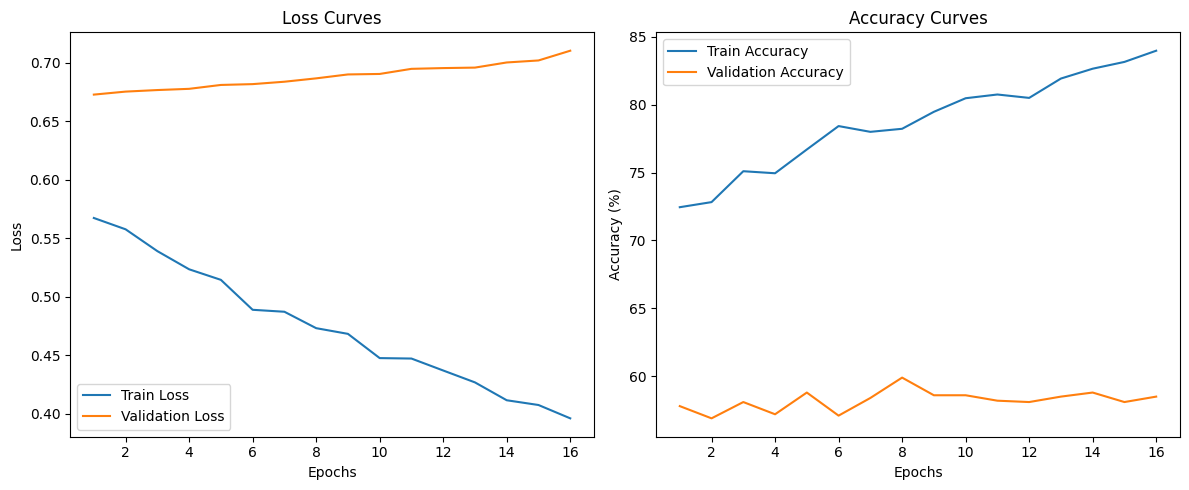

In [62]:
train_model(model_pretrained)